This is a code to analyze the current and voltage from a chosen tdms file. It is very similar to the previous one but calls a better function to create the database starting from the tdms file (i.e. you don't need to specify the channels manually, it finds automatically), so just select the tdms file and start to explore it.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tqdm import tqdm
import os
import lib_bbmdev
import logging
from datetime import datetime
import sys
from pathlib import Path

%matplotlib inline

In [2]:
#initialize
os.chdir(r'C:\Users\ggora\DevelopingToolkit\bbm_run2_tdms')
path = "Data/2023_run2/tdms/"
filename = "tdms102_room-to-cryo"


df_signal = lib_bbmdev.tdms_load_selected_custom(path + filename + ".tdms", samplerate=1000, print_=True)

created_directory = lib_bbmdev.create_directory(filename)
os.chdir(created_directory)

df_signal

Directory '202402291642_tdms102_room-to-cryo' has been created.


,time,Iu,Iv,Iw,A,B,Z,H,Count,Vu,Vv,Vw
0,0.000,-0.002150,0.005576,0.008808,1.105454,1.094131,-0.563824,0.112635,-10.380818,-0.002279,-0.007439,0.002983
1,0.001,-0.001511,0.004944,0.007852,1.105454,1.094131,-0.550140,0.111686,-10.380818,0.002865,0.007995,0.008128
2,0.002,-0.001511,0.004628,0.008171,1.103222,1.094447,-0.544730,0.108840,-10.380818,0.002865,-0.007439,0.002983
3,0.003,-0.001511,0.004944,0.007852,1.103860,1.094131,-0.543138,0.114533,-10.380818,-0.007424,-0.007439,0.002983
4,0.004,-0.001511,0.004944,0.007852,1.105773,1.093499,-0.554913,0.111370,-10.380818,0.002865,-0.007439,-0.002161
...,...,...,...,...,...,...,...,...,...,...,...,...
1378995,1378.995,-0.001192,0.004628,0.007214,1.103860,-10.375581,-0.876975,0.108523,-10.380818,0.002865,-0.002294,0.013272
1378996,1378.996,-0.001192,0.004312,0.007214,1.104817,-10.375581,-0.783730,0.113584,-10.380818,0.002865,-0.002294,-0.012451
1378997,1378.997,-0.001511,0.004312,0.007214,1.104817,-10.375581,-0.695577,0.113900,-10.380818,-0.002279,-0.002294,-0.002161
1378998,1378.998,-0.001192,0.004312,0.007214,1.104817,-10.375581,-0.629064,0.113268,-10.380818,0.002865,-0.002294,0.002983


In [3]:
# ログの設定
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# ログのフォーマットを設定
formatter = logging.Formatter('%(asctime)s - %(message)s')

# ログのファイル出力先を設定
log_file = 'analysis.log'
file_handler = logging.FileHandler(log_file)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# 解析開始時刻
start_time = datetime.now()

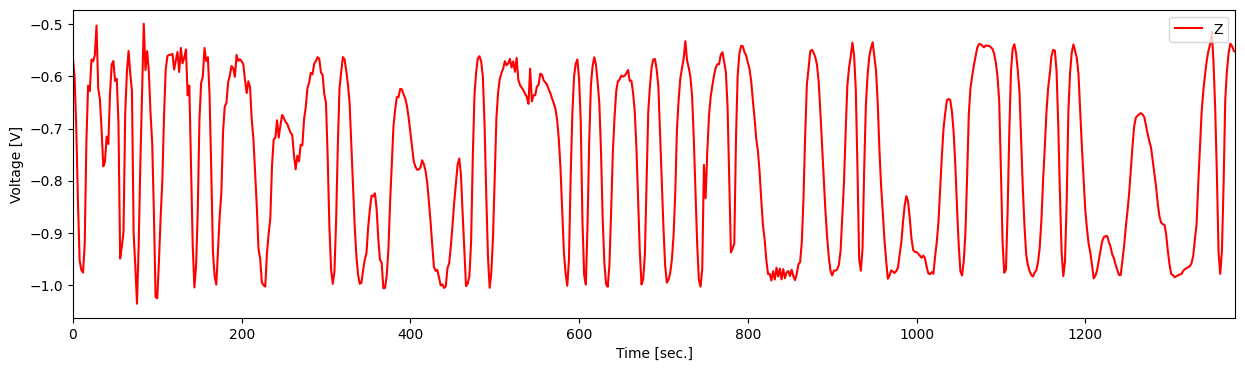

In [4]:
y_data = df_signal['Z'][::2000]
x_data = df_signal['time'][::2000]
fig, ax = plt.subplots(1, 1, figsize=(15, 4))

plot_data = [
    y_data
]
plot_labels = ["Z"]
plot_col = ["r"]
# Call the function with common time_data, multiple data arrays, and specified colors
lib_bbmdev.plot_multiple_arrays_with_time_and_color(
    ax,
    x_data,
    plot_data,
    labels=plot_labels,
    plot_col=plot_col,
)
# Customize the plot
lib_bbmdev.layout_coil_current_voltage(ax, "Time [sec.]", "Voltage [V]")
ax.autoscale(enable=True, axis="x", tight=True)
ax.autoscale(enable=True, axis="y", tight=False)
plt.legend(loc="upper right")

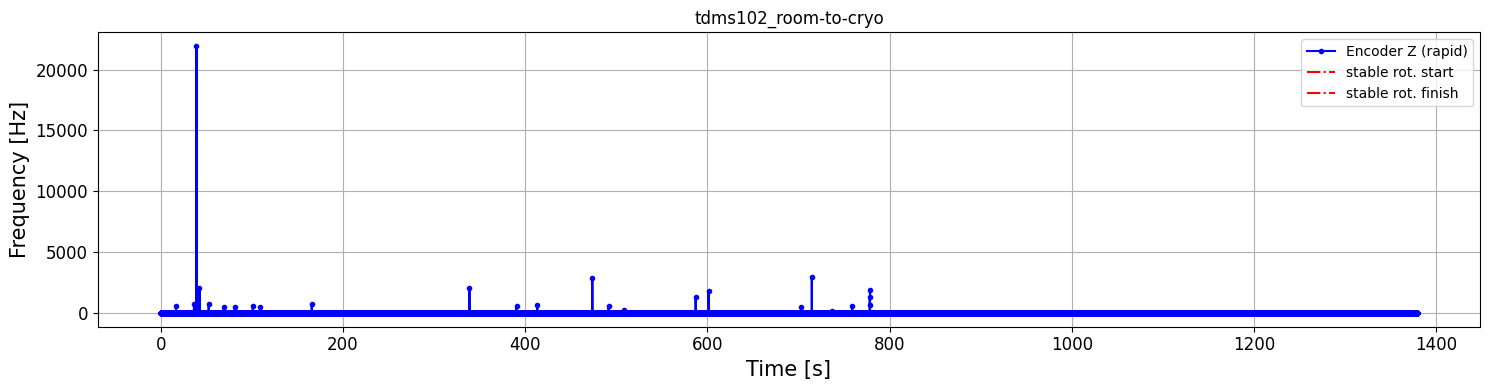

In [7]:
#%%time
#frequency
#encorder_threshold_high = 0.
#encorder_threshold_low = -4.

threshold,time_stamps=lib_bbmdev.triggerd_window(df_signal['Z'].to_numpy(),df_signal['time'].to_numpy(),high_threshold=-0.6,low_threshold=-0.9,window_size=5)
period,freq=lib_bbmdev.time2freq(time_stamps)

try:
    stable_index = np.where((freq>1.)&(freq<1.01))[0]
    stable_str = time_stamps[1:][stable_index[0]]
    stable_fin = time_stamps[1:][stable_index[-1]]
except:
    stable_str = np.inf
    stable_fin = np.inf

fig = plt.figure(figsize = (15,4))
ax = fig.add_subplot(111)
ax.plot(time_stamps[1:],freq,'b.-',label = 'Encoder Z (rapid)') # frequency
ax.axvline(x = stable_str,c = 'r',ls='-.',label = 'stable rot. start') # vertical line at the start
ax.axvline(x = stable_fin,c = 'r',ls='-.',label = 'stable rot. finish') # vertical line at the finish
ax.grid()
ax.set_xlabel('Time [s]',fontsize = 15)
ax.set_ylabel(r'Frequency [Hz]', fontsize = 15)
ax.tick_params(labelsize = 12)
ax.legend()
#ax.set_ylim(0,1.1)
#ax.set_ylim(0.2,0.27)
#ax.set_xlim(2100,2900)
ax.set_title(filename)
plt.tight_layout()
plt.savefig(
           "./" + "frequency.jpg",
           dpi=130,
       )
plt.show()


In [6]:
np.savez("phase.npz", x=time_stamps[1:], y=freq,stable_str=stable_str,stable_fin=stable_fin)

In [7]:
try:
    df_signal,cut_time = lib_bbmdev.Cut_start2(df_signal, 0.02, samplerate=1000)
    ax.axvline(x = cut_time ,c = 'r',ls='-.',label = 'cut line')
except Exception as e:
    print(e)

296.78000000000003


In [8]:
#median filter for voltage signal
window_size=5
df_signal['Vv_filterd'] = lib_bbmdev.medianfilter1D(df_signal['Vv'].to_numpy(),window_size)

C:\Users\ggora\AppData\Local\Temp\ipykernel_12428\855529961.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['Vv_filterd'] = lib_bbmdev.medianfilter1D(df_signal['Vv'].to_numpy(),window_size)


In [9]:
# columns array
plot_col = ["r","b","g"]
#U_lab = [df_signal.columns[1],df_signal.columns[8]]
U_lab = [df_signal.columns[2],df_signal.columns[-1]]
print(U_lab)

['Iv', 'Vv_filterd']


In [10]:
chunk_size = 2000
window_size=2000
#chunks = [df_signal['time'].iloc[i:i + chunk_size] fo\r i in range(0, len(df_signal), 100)]
chunks_time = [df_signal['time'].iloc[i:i + chunk_size] for i in range(0, len(df_signal), window_size)]
chunks_signal_I = [df_signal[U_lab[0]].iloc[i:i + chunk_size] for i in range(0, len(df_signal), window_size)]# そのままデータ数を増やすとforが終わらない
chunks_signal_V = [df_signal[U_lab[1]].iloc[i:i + chunk_size] for i in range(0, len(df_signal), window_size)]# そのままデータ数を増やすとforが終わらない
print(chunks_signal_I[0])
print(len(chunks_signal_I[0]))
print(chunks_signal_I[1])
print(len(chunks_signal_I[1]))

296780    0.330489
296781    0.334913
296782    0.339338
296783    0.341551
296784    0.345660
            ...   
298775    0.269805
298776    0.278022
298777    0.285292
298778    0.290981
298779    0.297934
Name: Iv, Length: 2000, dtype: float64
2000
298780    0.304887
298781    0.310893
298782    0.316266
298783    0.321639
298784    0.325116
            ...   
300775    0.336494
300776    0.331753
300777    0.327012
300778    0.322271
300779    0.317846
Name: Iv, Length: 2000, dtype: float64
2000


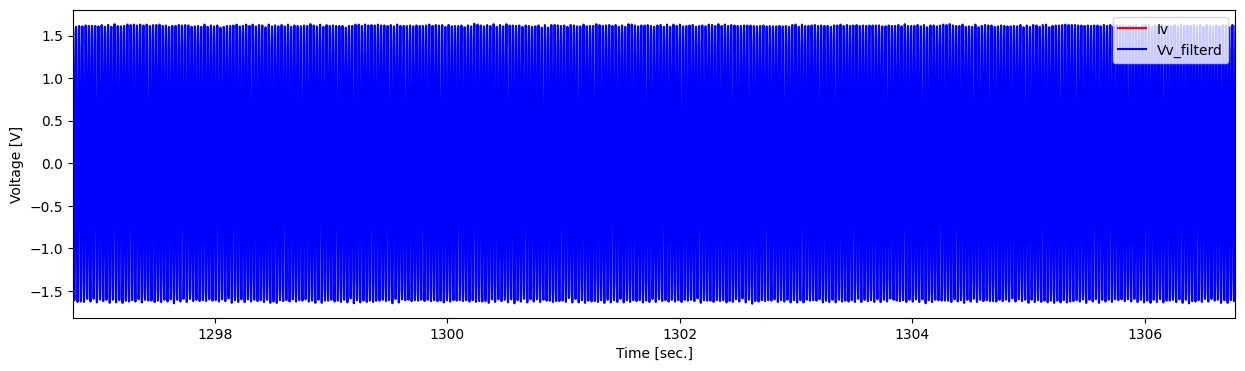

In [11]:
f_s = 1000
initial_time = 1000*f_s
time_window:int = 10*f_s
x_data = df_signal['time'][initial_time:time_window+initial_time:2]
fig, ax = plt.subplots(1, 1, figsize=(15, 4))

plot_data = [
    df_signal[U_lab[0]][initial_time:time_window+initial_time:2],df_signal[U_lab[1]][initial_time:time_window+initial_time:2]]
# Call the function with common time_data, multiple data arrays, and specified colors
lib_bbmdev.plot_multiple_arrays_with_time_and_color(
    ax,
    x_data,
    plot_data,
    labels=U_lab,
    plot_col=plot_col,
)
# Customize the plot
lib_bbmdev.layout_coil_current_voltage(ax, "Time [sec.]", "Voltage [V]")
ax.autoscale(enable=True, axis="x", tight=True)
ax.autoscale(enable=True, axis="y", tight=False)
plt.legend(loc="upper right")

sampling time :  0.0009999999999999833


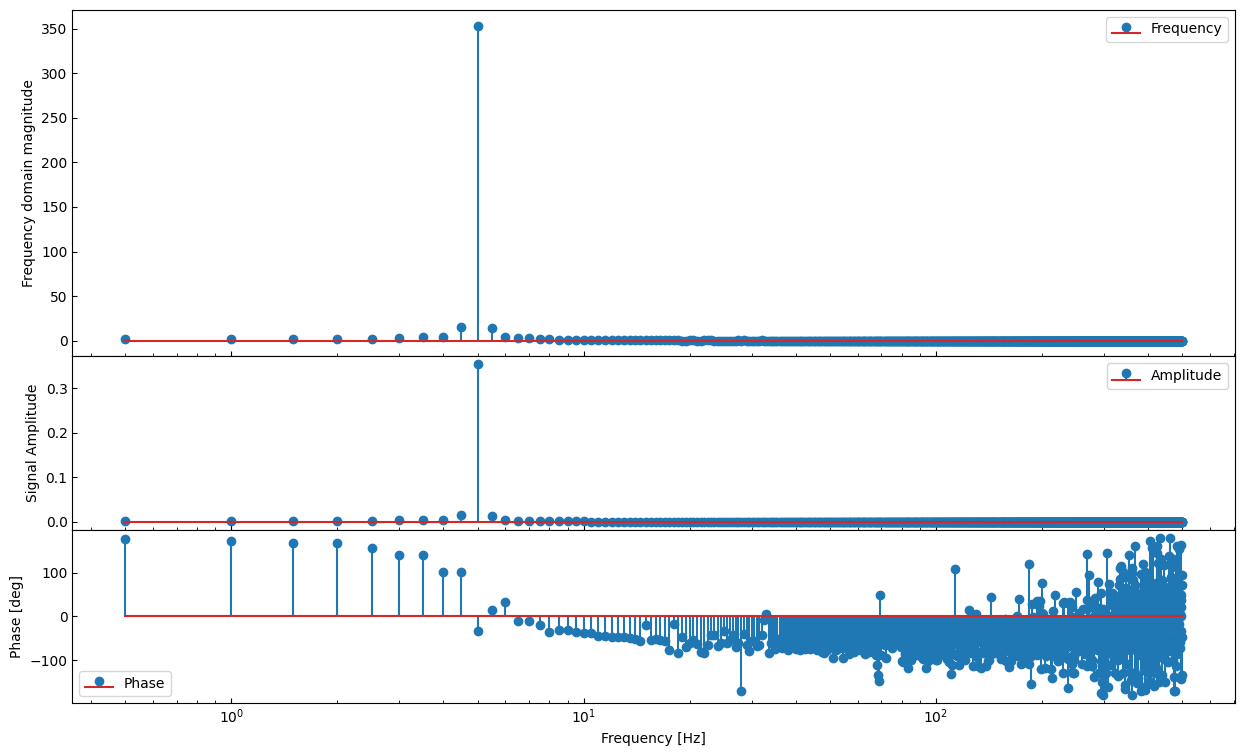

{'frequency': 5.0000000000000835, 'amplitude': 0.35323916158533575, 'degree': -33.82473645790916}
296780    296.780
296781    296.781
296782    296.782
296783    296.783
296784    296.784
           ...   
298775    298.775
298776    298.776
298777    298.777
298778    298.778
298779    298.779
Name: time, Length: 2000, dtype: float64


In [12]:
dt_s = abs(chunks_time[0].iloc[-1] - chunks_time[0].iloc[0]) / (len(chunks_time[0]) - 1) # sampling spacing calculated from time array
print('sampling time : ',dt_s)
y_fft,freqs,Amp_arr,Deg_arr = lib_bbmdev.fft_specgram([chunks_signal_I[0]],len(chunks_signal_I[0]),dt=dt_s,plot=True)

for i in range(0,len(y_fft),1):
    argmax_I,frequency,amp,deg_I = lib_bbmdev.fft_argmax(freqs,Amp_arr[i],Deg_arr[i],print_output=True)

print(chunks_time[0])

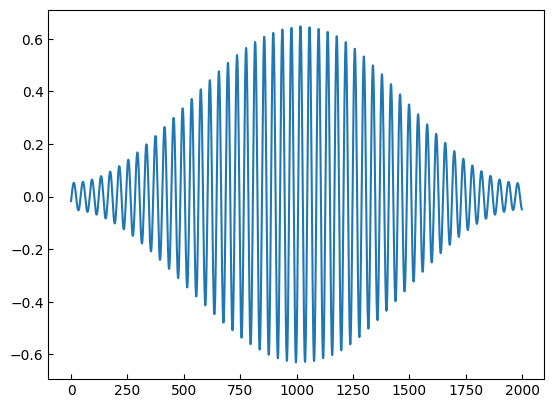

In [13]:
# hamming window
window = np.hamming(chunk_size+1)[:-1]
acf = 1/(sum(window)/(len(chunks_signal_I[0])+1)) #Amplitude Correction Factorを計算
slices_I = chunks_signal_I[:-11]
slices_V = chunks_signal_V[:-11]
chunks_signal_I_window = slices_I * window * acf # 全スライスに窓を掛け合わせる
chunks_signal_V_window = slices_V * window * acf
plt.plot(np.arange(0,len(chunks_signal_I_window[200])),chunks_signal_I_window[200])

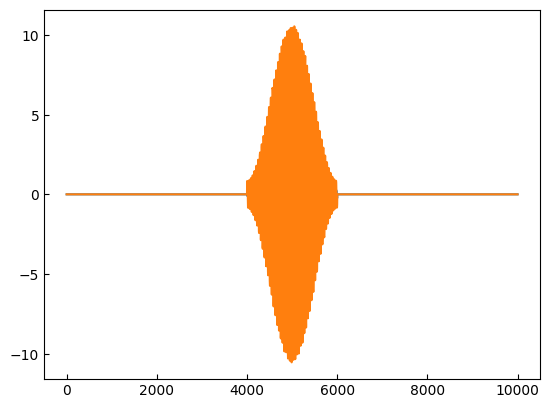

In [14]:
chunks_signal_I_padded = []
chunks_signal_V_padded = []
# zero padding
for chunk in chunks_signal_I_window:
    _chunks_signal_I_padded = np.pad(chunk, (4000, 4000), mode='constant') # for high frequency resolution
    acf = (sum(np.abs(chunk)) / len(chunk)) / (sum(np.abs(_chunks_signal_I_padded)) / len(_chunks_signal_I_padded))
    _chunks_signal_I_padded = _chunks_signal_I_padded*acf
    chunks_signal_I_padded.append(_chunks_signal_I_padded)

for chunk in chunks_signal_V_window:
    _chunks_signal_V_padded = np.pad(chunk, (4000, 4000), mode='constant') # for high frequency resolution
    acf = (sum(np.abs(chunk)) / len(chunk)) / (sum(np.abs(_chunks_signal_V_padded)) / len(_chunks_signal_V_padded))
    _chunks_signal_V_padded = _chunks_signal_V_padded*acf
    chunks_signal_V_padded.append(_chunks_signal_V_padded)

plt.plot(np.arange(0,len(chunks_signal_I_padded[200])),chunks_signal_I_padded[200])
plt.plot(np.arange(0,len(chunks_signal_V_padded[200])),chunks_signal_V_padded[200])

sampling time :  0.0009999999999999833


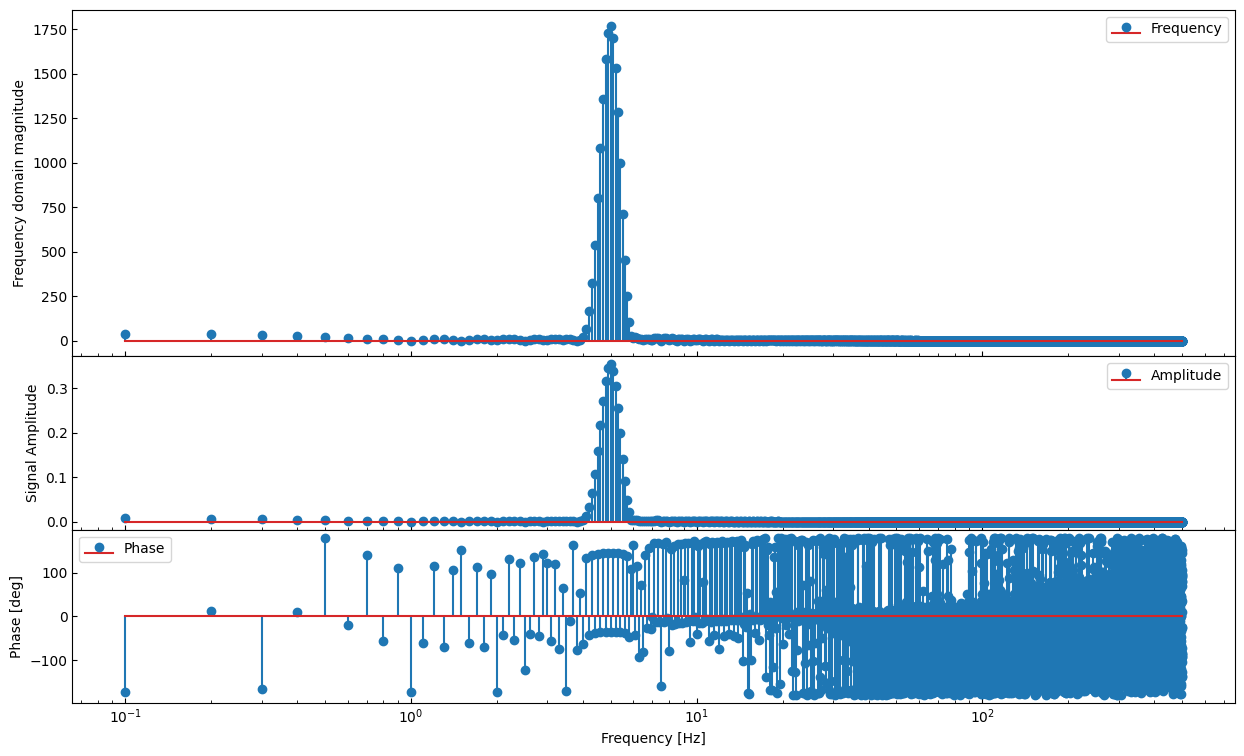

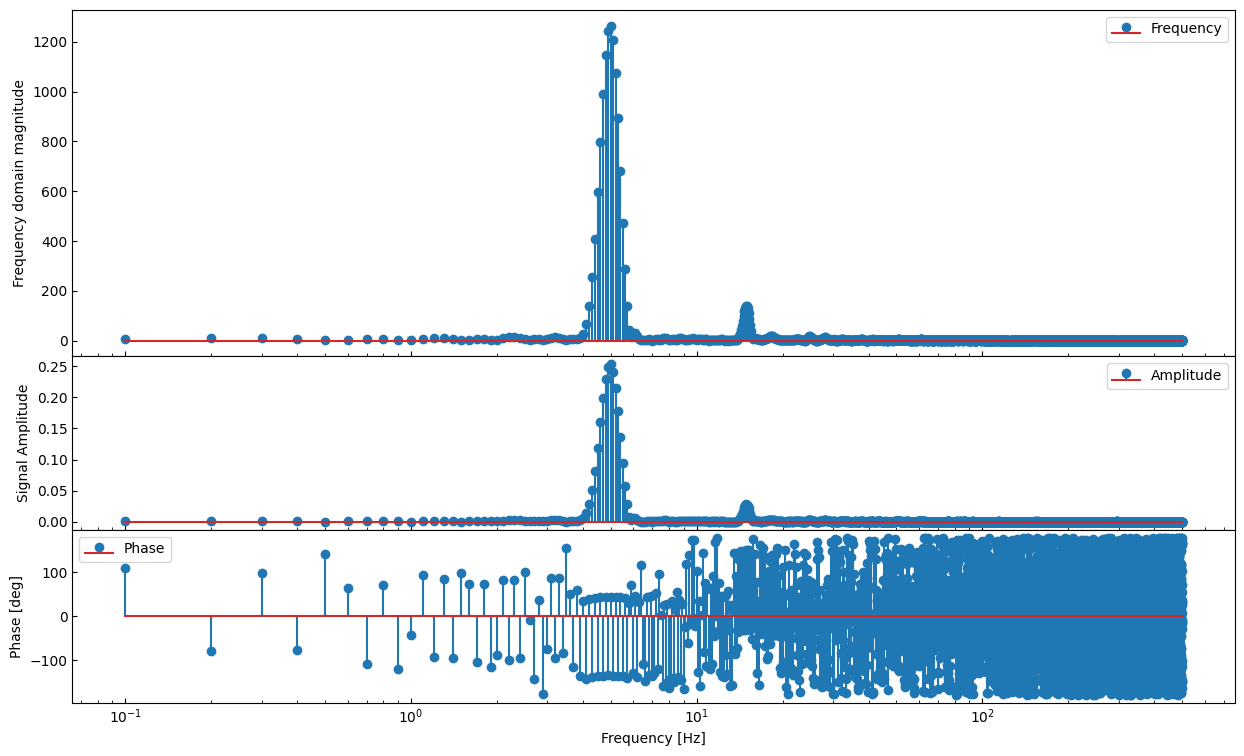

In [29]:
# fft
dt_s = abs(chunks_time[0].iloc[-1] - chunks_time[0].iloc[0]) / (len(chunks_time[0]) - 1) # sampling spacing calculated from time array
print('sampling time : ',dt_s)

fft_I,freqs_I,Amp_arr_I,Deg_arr_I = lib_bbmdev.fft_specgram(chunks_signal_I_padded,len(chunks_signal_I_padded[0]),dt=dt_s,plot=True)
fft_V,freqs_V,Amp_arr_V,Deg_arr_V = lib_bbmdev.fft_specgram(chunks_signal_V_padded,len(chunks_signal_V_padded[0]),dt=dt_s,plot=True)

In [16]:
#relative_phase
U_IV = []
relative_phase_U = []

for chunk_num in tqdm(range(0,len(fft_I),1), desc="Calculating phase..."):
    IV_chunk = slices_I[chunk_num]*slices_V[chunk_num]
    IV_average = np.average(IV_chunk)
    U_IV.append(IV_average)

    argmax_I,frequency,amp,deg_I = lib_bbmdev.fft_argmax(freqs_I,Amp_arr_I[chunk_num],Deg_arr_I[chunk_num],print_output=False)
    argmax,frequency,amp,deg_V = lib_bbmdev.fft_argmax(freqs_V,Amp_arr_V[chunk_num],Deg_arr_V[chunk_num],argmax=argmax_I,print_output=False)
    relative_phase_U.append(np.abs(deg_V-deg_I))

    if chunk_num % 50 == 0:
        fig, ax = plt.subplots(1, 1, figsize=(15, 4))

        plot_data = [
            slices_I[chunk_num],
            slices_V[chunk_num],
            IV_chunk,
        ]
        plot_labels = ["U_I", "U_V", "U_I*V)", "Average"]
        plot_col = ["r", "b", "g", "black"]
        # Call the function with common time_data, multiple data arrays, and specified colors
        lib_bbmdev.plot_multiple_arrays_with_time_and_color(
            ax,
            chunks_time[chunk_num],
            plot_data,
            labels=plot_labels,
            plot_col=plot_col,
        )
        # Customize the plot
        lib_bbmdev.layout_coil_current_voltage(ax, "Time [sec.]", "Current [A]")
        ax.set_title("t="+str(int(chunks_time[chunk_num].iloc[0]))+" sec")
        ax.autoscale(enable=True, axis="x", tight=True)
        ax.autoscale(enable=True, axis="y", tight=False)
        plt.legend(loc="upper right")
        plt.tight_layout()
        plt.savefig(
            "./" + str(int(chunks_time[chunk_num].iloc[0])) + "_waveform.jpg",
            dpi=130,
        )
        plt.close()

Calculating phase...: 100%|██████████| 1665/1665 [00:12<00:00, 133.79it/s]


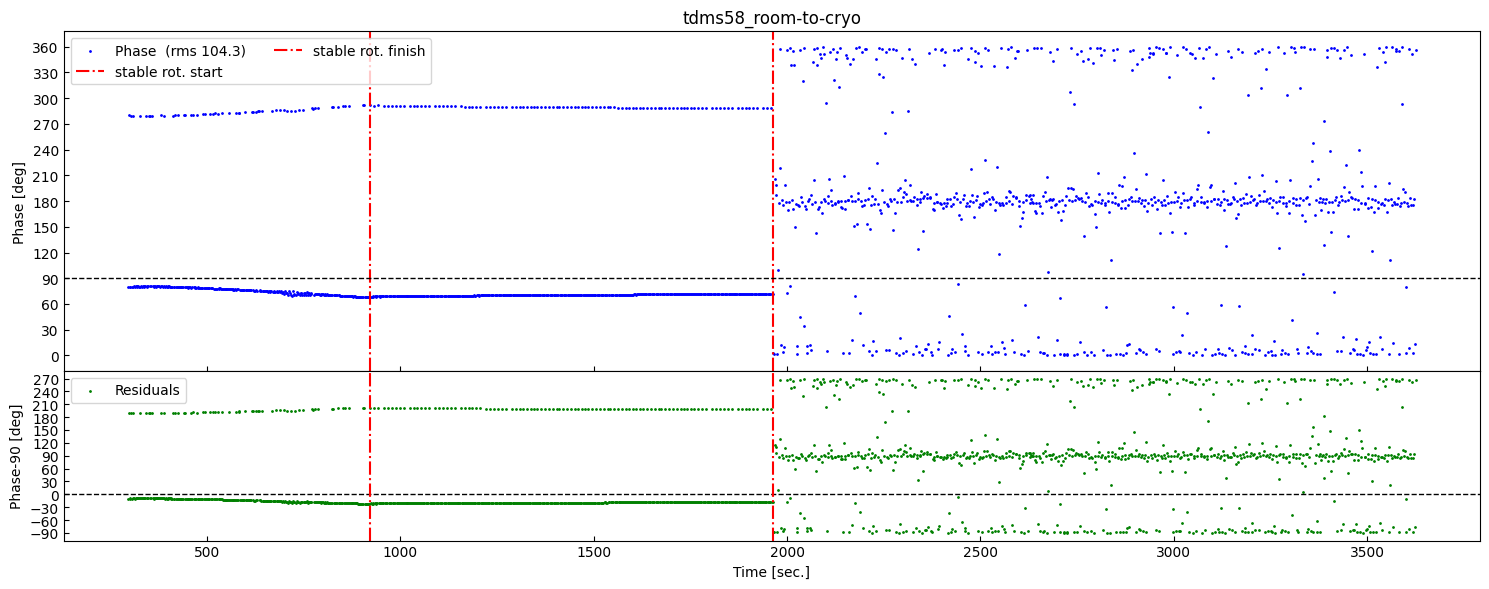

In [17]:
# phase plot
from matplotlib.ticker import MultipleLocator
y_data = np.array(relative_phase_U)
#for i in range(len(y_data)):
    #if y_data[i] >180:
        #y_data[i]=360-y_data[i]
x_data = np.arange(0, len(y_data) * chunk_size / f_s, chunk_size / f_s) +cut_time
rms_y = np.std(y_data)

# FigureとAxesの作成
fig = plt.figure(figsize=(15, 6))

# グリッドの設定 (2行, 1列)
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0.0)

# 上のsubplot: フィット結果の関数とデータ点のプロット
ax0 = plt.subplot(gs[0])
plt.gca().yaxis.set_major_locator(MultipleLocator(30))
# ax0.plot(x_data, y_data,"b.-", label='Data Points')
ax0.scatter(
    x_data, y_data, s=1, c="b", label="Phase  (rms " + str(round(rms_y, 2)) + ")"
)
ax0.axvline(
    x=stable_str, c="r", ls="-.", label="stable rot. start"
)  # vertical line at the start
ax0.axvline(
    x=stable_fin, c="r", ls="-.", label="stable rot. finish"
)  # vertical line at the finish
ax0.axhline(90, color="black", linestyle="--", linewidth=1)
ax0.legend(ncol=2)
ax0.set_ylabel("Phase [deg]")
#ax0.set_ylim(0, 180)
ax0.set_title(filename)


# 下のsubplot: フィット結果の関数とデータ点の差分プロット
ax1 = plt.subplot(gs[1], sharex=ax0)  # x軸を共有
plt.gca().yaxis.set_major_locator(MultipleLocator(30))
residuals = y_data - 90.0
ax1.scatter(x_data, residuals, s=1, c="g", label="Residuals")
ax1.axhline(0, color="black", linestyle="--", linewidth=1)
ax1.axvline(
    x=stable_str, c="r", ls="-."
)  # ,label = 'stable rot. start') # vertical line at the start
ax1.axvline(
    x=stable_fin, c="r", ls="-."
)  # ,label = 'stable rot. finish') # vertical line at the finish
lib_bbmdev.layout_coil_current_voltage(ax1, "Time [sec.]", "Phase-90 [deg]")
ax1.legend()
#ax1.set_ylim(-90, 89)
# ax1.set_xlim(0,10000)

# 上のsubplotのx軸ラベルを非表示にする
plt.tight_layout()
plt.setp(ax0.get_xticklabels(), visible=False)
plt.savefig(
    "./" + "relative_phase_difference_U.jpg",
    dpi=130,
)
# グラフの表示
plt.show()

In [18]:
np.savez("phase.npz", x=x_data, y=y_data,res=residuals,stable_str=stable_str,stable_fin=stable_fin)

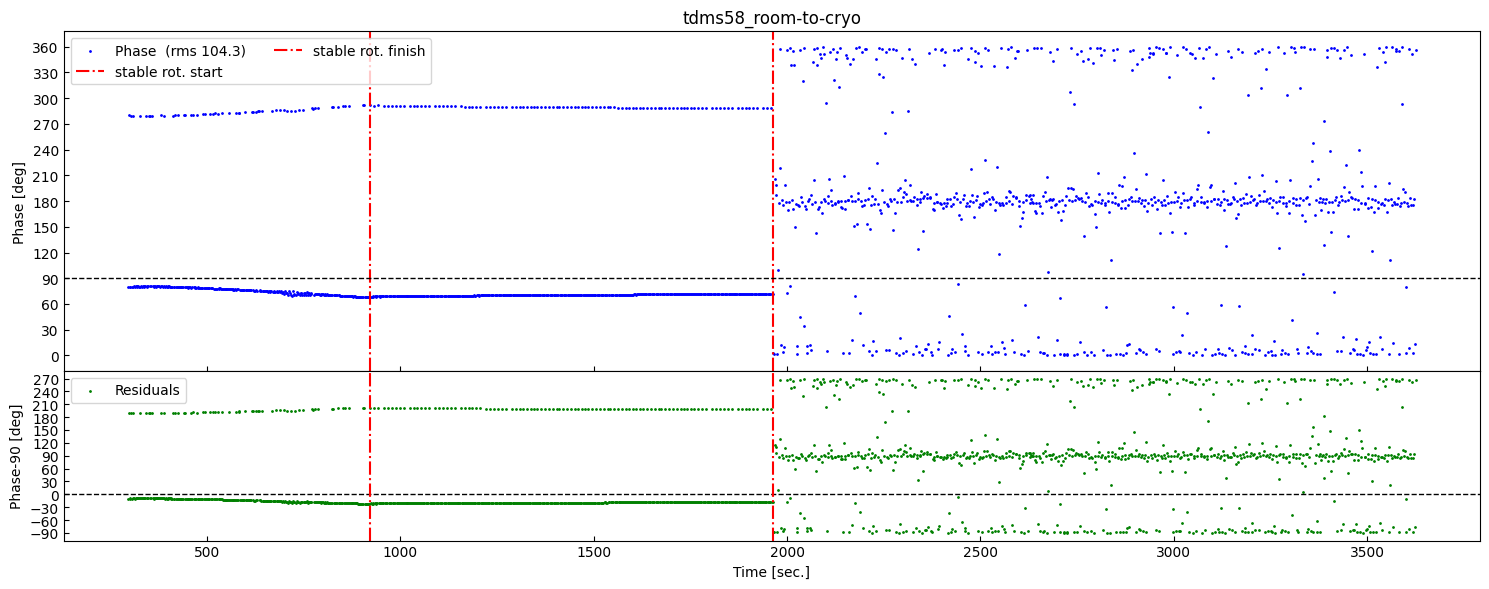

In [19]:
# phase plot
from matplotlib.ticker import MultipleLocator
y_data = np.array(relative_phase_U)
#for i in range(len(y_data)):
    #if y_data[i] >180:
        #y_data[i]=360-y_data[i]
x_data = np.arange(0, len(y_data) * chunk_size / f_s, chunk_size / f_s) +cut_time
rms_y = np.std(y_data)

# FigureとAxesの作成
fig = plt.figure(figsize=(15, 6))

# グリッドの設定 (2行, 1列)
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0.0)

# 上のsubplot: フィット結果の関数とデータ点のプロット
ax0 = plt.subplot(gs[0])
plt.gca().yaxis.set_major_locator(MultipleLocator(30))
# ax0.plot(x_data, y_data,"b.-", label='Data Points')
ax0.scatter(
    x_data, y_data, s=1, c="b", label="Phase  (rms " + str(round(rms_y, 2)) + ")"
)
ax0.axvline(
    x=stable_str, c="r", ls="-.", label="stable rot. start"
)  # vertical line at the start
ax0.axvline(
    x=stable_fin, c="r", ls="-.", label="stable rot. finish"
)  # vertical line at the finish
ax0.axhline(90, color="black", linestyle="--", linewidth=1)
ax0.legend(ncol=2)
ax0.set_ylabel("Phase [deg]")
#ax0.set_ylim(0, 180)
ax0.set_title(filename)


# 下のsubplot: フィット結果の関数とデータ点の差分プロット
ax1 = plt.subplot(gs[1], sharex=ax0)  # x軸を共有
plt.gca().yaxis.set_major_locator(MultipleLocator(30))
residuals = y_data - 90.0
ax1.scatter(x_data, residuals, s=1, c="g", label="Residuals")
ax1.axhline(0, color="black", linestyle="--", linewidth=1)
ax1.axvline(
    x=stable_str, c="r", ls="-."
)  # ,label = 'stable rot. start') # vertical line at the start
ax1.axvline(
    x=stable_fin, c="r", ls="-."
)  # ,label = 'stable rot. finish') # vertical line at the finish
lib_bbmdev.layout_coil_current_voltage(ax1, "Time [sec.]", "Phase-90 [deg]")
ax1.legend()
#ax1.set_ylim(-90, 89)
#ax1.set_xlim(7800,9100)
#ax1.set_xlim(0,2000)

# 上のsubplotのx軸ラベルを非表示にする
plt.tight_layout()
plt.setp(ax0.get_xticklabels(), visible=False)

'''plt.savefig(
    "./" + "relative_phase_difference_U.jpg",
    dpi=130,
)
'''
# グラフの表示
plt.show()

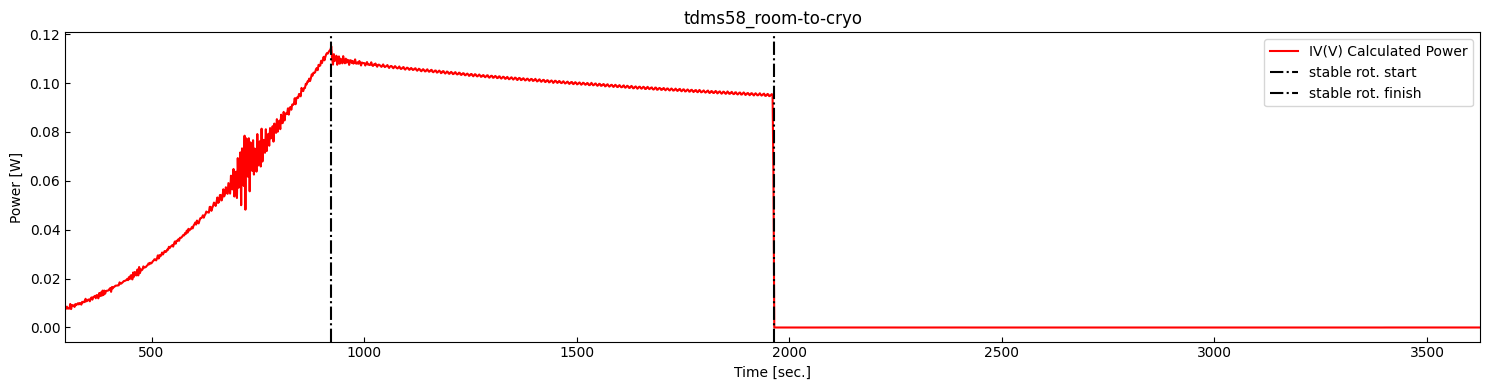

In [20]:
y_data = np.array(U_IV)
y_data[np.isnan(y_data)] = 0.
x_data = np.arange(0, len(y_data) * chunk_size / f_s, chunk_size / f_s)+cut_time
fig, ax = plt.subplots(1, 1, figsize=(15, 4))

plot_data = [y_data]
plot_labels = ["IV(V) Calculated Power"]
plot_col = ["r"]
# Call the function with common time_data, multiple data arrays, and specified colors
lib_bbmdev.plot_multiple_arrays_with_time_and_color(
    ax,
    x_data,
    plot_data,
    labels=plot_labels,
    plot_col=plot_col,
)
# Customize the plot
ax.axvline(x = stable_str,c = 'black',ls='-.',label = 'stable rot. start') # vertical line at the start
ax.axvline(x = stable_fin,c = 'black',ls='-.',label = 'stable rot. finish') # vertical line at the finish
lib_bbmdev.layout_coil_current_voltage(ax, "Time [sec.]", "Power [W]")
ax.autoscale(enable=True, axis="x", tight=True)
ax.autoscale(enable=True, axis="y", tight=False)
ax.set_title(filename)
plt.tight_layout()
plt.legend(loc="upper right")
plt.savefig(
    "./" + "Power.jpg",
    dpi=130,
)

In [21]:
np.savez("power.npz", x=x_data, y=y_data,stable_str=stable_str,stable_fin=stable_fin)

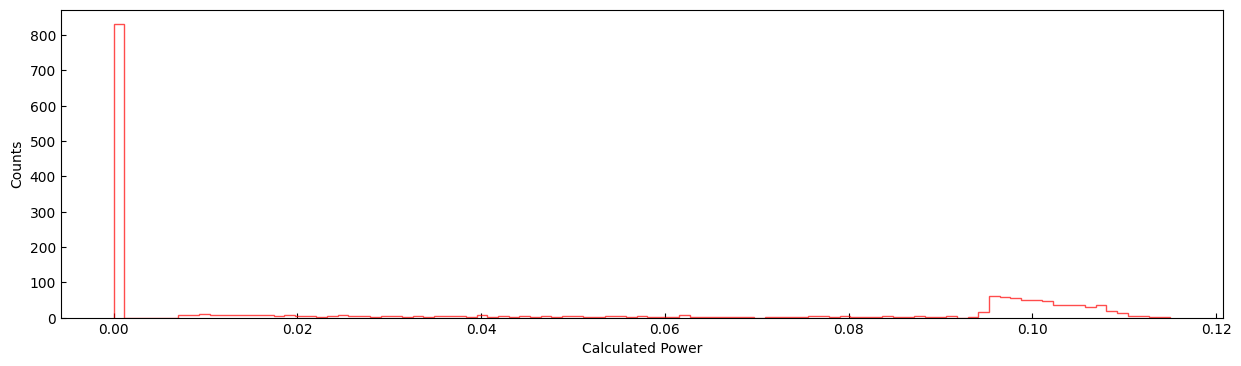

In [22]:

max_value = max(U_IV)
min_value = min(U_IV)

hist, bins = np.histogram(U_IV, bins=np.linspace(min_value,max_value,100))


# FigureとAxesの作成
fig, ax = plt.subplots(1, 1, figsize=(15, 4))

# ヒストグラムの可視化
ax.hist(U_IV, bins=bins, color='r', alpha=0.7,histtype="step")
ax.set_xlabel('Calculated Power')
ax.set_ylabel('Counts')

# 表示
plt.show()


In [23]:
x = np.array(chunks_time[:-11])[:, -1]
x_l = x[0]
x_r = x[-1]
y_u = freqs_I[-1]
y_d = freqs_I[0]

Z = np.abs(np.array(Amp_arr_I).T)
extent = (x_l, x_r, y_d, y_u)

fig, ax = plt.subplots()
img = ax.imshow(Z,cmap='viridis', origin='lower',extent=extent, aspect='auto')
fig.colorbar(img, ax=ax,label='Amplitude')

# 軸ラベルの追加
ax.set_xlabel('time / sec')
ax.set_ylabel('Frequency / Hz')
ax.set_ylim(1,50)
ax.axvline(
    x=stable_str, c="r", ls="-."
)
ax.axvline(
    x=stable_fin, c="r", ls="-."
)

# タイトルの追加
ax.set_title('Current Amplitude spectrogram')
plt.savefig(
    "./" + "Amplitude_spectrogram_I.jpg",
    dpi=130,
)
plt.close()

In [24]:
np.savez("Current_spectrogram.npz", z=Z, extent=extent, stable_str=stable_str,stable_fin=stable_fin)

In [25]:
x = np.array(chunks_time[:-11])[:, -1]
x_l = x[0]
x_r = x[-1]
y_u = freqs_V[-1]
y_d = freqs_V[0]

Z = np.abs(np.array(Amp_arr_V).T)
extent = (x_l, x_r, y_d, y_u)

fig, ax = plt.subplots()
img = ax.imshow(Z,cmap='viridis', origin='lower',extent=extent, aspect='auto')
fig.colorbar(img, ax=ax,label='Amplitude')

# 軸ラベルの追加
ax.set_xlabel('time / sec')
ax.set_ylabel('Frequency / Hz')
ax.set_ylim(1,50)
ax.axvline(
    x=stable_str, c="r", ls="-."
)
ax.axvline(
    x=stable_fin, c="r", ls="-."
)

# タイトルの追加
ax.set_title('Voltage Amplitude spectrogram')
plt.savefig(
    "./" + "Amplitude_spectrogram_V.jpg",
    dpi=130,
)
plt.close()

In [26]:
np.savez("Voltage_spectrogram.npz", z=Z, extent=extent, stable_str=stable_str,stable_fin=stable_fin)

In [27]:
# 解析終了時刻
end_time = datetime.now()

# ログに情報を記録
logging.info(f"program name: {Path().resolve()}")
logging.info(f"tdms name: {filename}")
logging.info(f"start time: {start_time}")
logging.info(f"finish time: {end_time}")

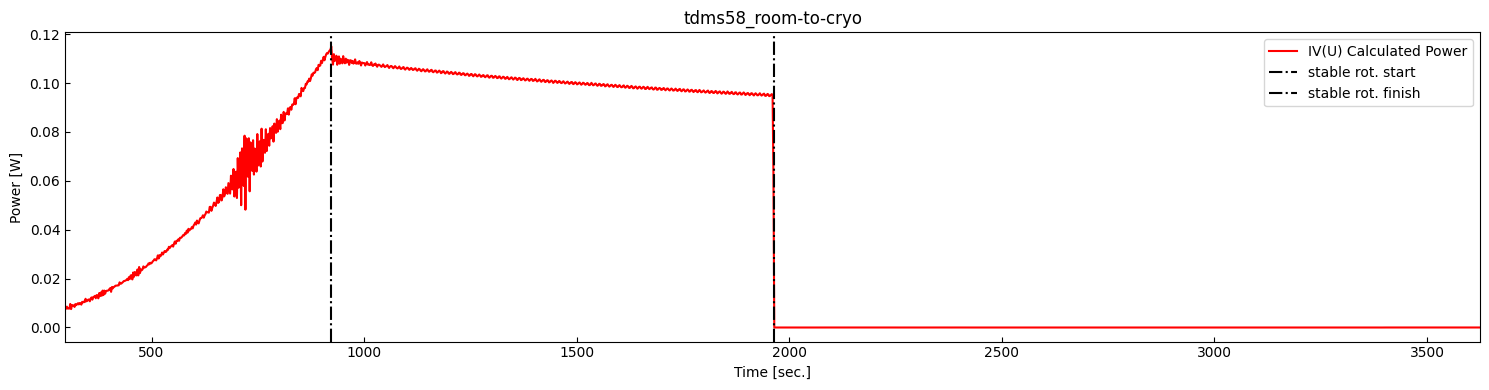

In [28]:
# making plot from npz
data = np.load("power.npz")

y_data = data['y']
x_data = data['x']
fig, ax = plt.subplots(1, 1, figsize=(15, 4))

plot_data = [y_data]
plot_labels = ["IV(U) Calculated Power"]
plot_col = ["r"]
# Call the function with common time_data, multiple data arrays, and specified colors
lib_bbmdev.plot_multiple_arrays_with_time_and_color(
    ax,
    x_data,
    plot_data,
    labels=plot_labels,
    plot_col=plot_col,
)
# Customize the plot
ax.axvline(x = stable_str,c = 'black',ls='-.',label = 'stable rot. start') # vertical line at the start
ax.axvline(x = stable_fin,c = 'black',ls='-.',label = 'stable rot. finish') # vertical line at the finish
lib_bbmdev.layout_coil_current_voltage(ax, "Time [sec.]", "Power [W]")
ax.autoscale(enable=True, axis="x", tight=True)
ax.autoscale(enable=True, axis="y", tight=False)
ax.set_title(filename)
plt.tight_layout()
plt.legend(loc="upper right")
plt.savefig(
    "./" + "Power.jpg",
    dpi=130,
)